In [1]:
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from data_train_test_funcs import mnist_dataloaders, train, sample_images

### Parameters

In [2]:
gpu = True
batch_size = 128
num_workers = 4
epochs = 200
critic_upd_steps = 5

### Dataset definition

In [3]:
train_loader, test_loader = mnist_dataloaders(batch_size=batch_size, num_workers=num_workers, pin_memory=gpu)

### Network definition

In [4]:
class ClampWeights:
    r"""Simple clipping functionality that will clip weights of module if it has such a tensor."""
    def __init__(self, low, high):
        self.low = low
        self.high = high

    def __call__(self, module):
        if hasattr(module, "weight"):
            module.weight.data.clamp_(self.low, self.high)
            
            
class Generator(nn.Module):
    def __init__(self, l_sizes, activation="relu", noise_prior="uniform"):
        super(Generator, self).__init__()
        
        self.l_sizes = [*l_sizes, 784]
        self.activation = activation
        
        # Set noise prior
        if noise_prior == "uniform":
            self.noise_prior = torch.distributions.Uniform(0, 1)
        elif noise_prior == "normal":
            self.noise_prior = torch.distributions.Normal(0, 1)
        else:
            raise ValueError("No valid prior distribution type selected")
        
        # Generator activation function generator
        if activation == "relu":
            act_fun = nn.ReLU
        elif activation == "leakyrelu":
            act_fun = nn.LeakyReLU
        elif activation == "sigmoid":
            act_fun == nn.Sigmoid
        else:
            raise ValueError("No valid activation function selected")
        
        # Generator
        gen_layers = []
        for idx in range(len(self.l_sizes[:-1])):
            gen_layers.append((f"fc{idx}", nn.Linear(self.l_sizes[idx], self.l_sizes[idx+1])))
            if idx != (len(self.l_sizes) - 2):
                gen_layers.append((f"{activation}{idx}", act_fun()))
            else:  # Sigmoid for final layer
                gen_layers.append((f"sigmoid{idx}", nn.Tanh()))
            
        gen_dict = OrderedDict(gen_layers)
        self.generator = nn.Sequential(gen_dict)
        print(self.generator)
        
    def noise(self, batch_size):
        device = next(self.parameters()).device
        noise = self.noise_prior.rsample((batch_size, self.l_sizes[0]))
        return noise
        
    def forward(self, x):
        y = self.generator(x)
        return y
        
        
class Critic(nn.Module):
    def __init__(self, l_sizes, activation="relu"):
        super(Critic, self).__init__()
        
        self.l_sizes = [784, *l_sizes, 1]
        self.activation = activation
        
        # Discriminator activation function generator
        if activation == "relu":
            act_fun = nn.ReLU
        elif activation == "leakyrelu":
            act_fun = nn.LeakyReLU
        elif activation == "sigmoid":
            act_fun == nn.Sigmoid
        else:
            raise ValueError("No valid activation function selected")
            
        # Discriminator
        critic_layers = []
        for idx in range(len(self.l_sizes[:-1])):
            critic_layers.append((f"fc{idx}", nn.Linear(self.l_sizes[idx], self.l_sizes[idx+1])))
            if idx != (len(self.l_sizes) - 2):
                critic_layers.append((f"{activation}{idx}", act_fun()))
            else:  # Sigmoid for final layer
                critic_layers.append((f"sigmoid{idx}", nn.Sigmoid()))
            
        critic_dict = OrderedDict(critic_layers)
        self.critic = nn.Sequential(critic_dict)
        print(self.critic)
        
    def forward(self, x):
        x = x.view(-1, 784)
        y = self.critic(x)
        return y

### Training

In [5]:
# Gen
gen_layers = [32, 128, 256, 512]
generator = Generator(gen_layers, activation="leakyrelu", noise_prior="normal")
gen_optimizer = optim.RMSprop(generator.parameters(), 0.00005)

# Critic
critic = Critic([512, 256, 128], activation="leakyrelu")
critic_optimizer = optim.RMSprop(critic.parameters(), 0.00005)

Sequential(
  (fc0): Linear(in_features=32, out_features=128, bias=True)
  (leakyrelu0): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (leakyrelu1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (leakyrelu2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
  (sigmoid3): Tanh()
)
Sequential(
  (fc0): Linear(in_features=784, out_features=512, bias=True)
  (leakyrelu0): LeakyReLU(negative_slope=0.01)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (leakyrelu1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (leakyrelu2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid3): Sigmoid()
)


In [6]:
def train_step(batch, b_idx):
    
    # generate samples
    x = batch[0]
    noise = generator.noise(x.shape[0]).to(x.device)
    gen_samples = generator(noise)
    critic_optimizer.zero_grad()
    
    # Get critic output for true and generated samples
    true_crit = critic(x)
    generated_crit = critic(gen_samples.detach())
    
    # Perform optimization step
    critic_loss = - true_crit.mean() + generated_crit.mean()
    critic_loss.backward()
    critic_optimizer.step()
    
    # Clamp weights
    for param in critic.parameters():
        param.data.clamp_(-0.01, 0.01)
    
    # Generator update every N steps
    if (b_idx % critic_upd_steps) == 0:
        gen_optimizer.zero_grad()
        
        # Generate new images
        gen_samples = generator(noise)
        # Run generated images through critic
        generated_crit = critic(gen_samples)
        gen_loss = - generated_crit.mean()
        gen_loss.backward()
        gen_optimizer.step()
        
    else:
        gen_loss = torch.tensor(0)
        
    return OrderedDict([
        ("Critic loss", critic_loss.item()),
        ("Generator loss", gen_loss.item()),
    ])

In [7]:
train(train_step, [generator, critic], train_loader, epochs=epochs, gpu=gpu)

cuda


100%|██████████| 200/200 [08:30<00:00,  2.54s/it, Critic loss=-.0388, Generator loss=0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


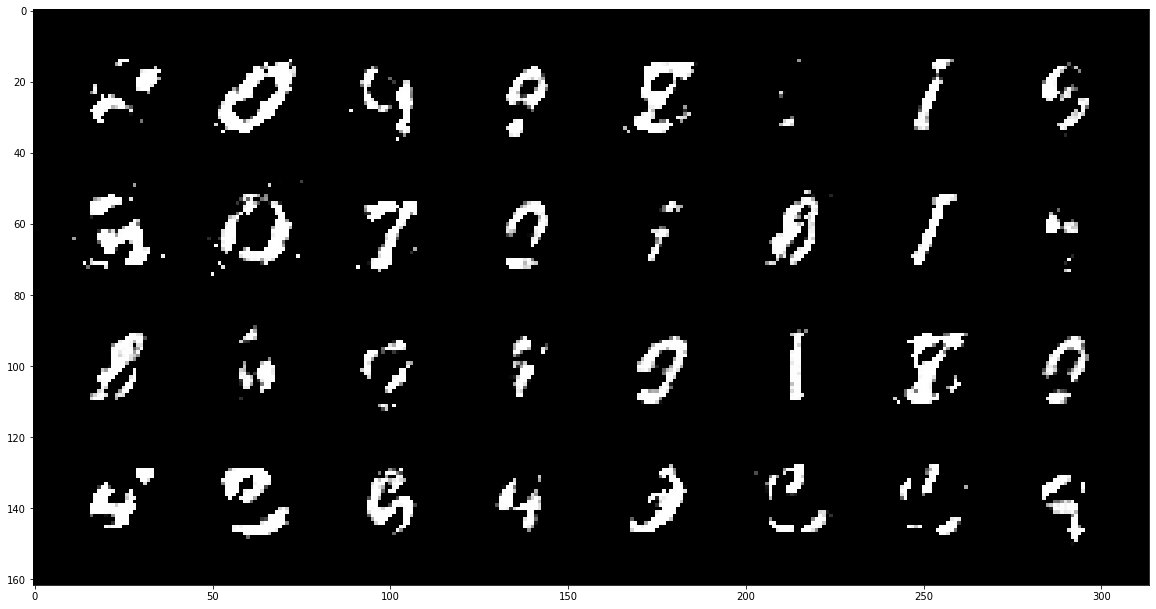

In [8]:
sample_images(generator, generator.noise(32).cpu())